In [4]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [5]:
from keras import datasets, layers, models
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input,Flatten

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
POS_PATH = '/content/drive/MyDrive/FaceID/data/positive'
NEG_PATH = '/content/drive/MyDrive/FaceID/data/negative'
ANC_PATH = '/content/drive/MyDrive/FaceID/data/anchor'

In [8]:
format(uuid.uuid1())

'1e850678-afcb-11ed-8705-0242ac1c000c'

Get Image Paths

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'/content/drive/MyDrive/FaceID/data/anchor/46950f18-afa1-11ed-a438-0045e24e4b3a.jpg'


Changing the Size of photos

In [12]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [13]:
img = preprocess('/content/drive/MyDrive/FaceID/data/anchor/8937293d-afa1-11ed-9745-0045e24e4b3a.jpg')
img.numpy().max() 


0.6647059

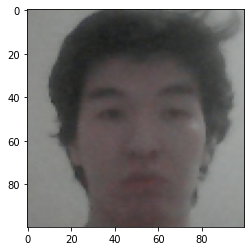

In [14]:
plt.imshow(img)

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

Prepocess all dataset

In [17]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

Sepearating train and test sets

In [18]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [19]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

**Creating a model** 

Creating an *Embedding* model to convert our raw image into data representation

In [20]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [21]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [22]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [23]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [24]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

distance layer

In [25]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [26]:
l1 = L1Dist()
#l1(anchor_embedding, validation_embedding)

In [27]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)

classifier = Dense(1, activation='sigmoid')(distances)

siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [28]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [29]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [30]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

Optimizer

In [31]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [32]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]  

Separating **X** and **Y**

In [33]:
@tf.function
def train_step(batch):
    
    
    with tf.GradientTape() as tape:     
       
        X = batch[:2]
        
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

Making a train loop

In [34]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

In [35]:
EPOCHS = 5

In [37]:
train(train_data, EPOCHS)


 Epoch 1/15


KeyboardInterrupt: ignored

In [ ]:
# Import metric calculations
from keras.metrics import Precision, Recall

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

In [ ]:
y_true

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

Visualization results

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [ ]:
# Save weights
siamese_model.save('siamesemodel.h5')

# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

Testing on new images

In [38]:
for image in os.listdir('/content/drive/MyDrive/FaceID/verification_images'):
    validation_img = os.path.join('/content/drive/MyDrive/FaceID/verification_images', image)
    print(validation_img)

/content/drive/MyDrive/FaceID/verification_images/c694112f-afa1-11ed-83b3-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/c9972abf-afa1-11ed-8d76-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/c9670c30-afa1-11ed-a630-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/cba8af1f-afa1-11ed-9cf6-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/cb73199b-afa1-11ed-943d-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/cbd673e0-afa1-11ed-87d7-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/cc952566-afa1-11ed-99fc-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/ccac2a56-afa1-11ed-b9ae-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/ceb0c4a2-afa1-11ed-8b24-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/d0cc3f07-afa1-11ed-ba6f-0045e24e4b3a.jpg
/content/drive/MyDrive/FaceID/verification_images/d197ea77-afa1-11ed-9381-0045e24e4b3a.jpg

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir( '/content/drive/MyDrive/FaceID/verification_images')):
        input_img = preprocess(os.path.join('/content/drive/MyDrive/FaceID/input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join( '/content/drive/MyDrive/FaceID/verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('/content/drive/MyDrive/FaceID/verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified